In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
train = pd.read_csv('./sign_mnist_train/sign_mnist_train.csv')
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [3]:
test = pd.read_csv('./sign_mnist_test/sign_mnist_test.csv')
y = test['label']

C:\Users\Diksha\Anaconda3\envs\keras\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

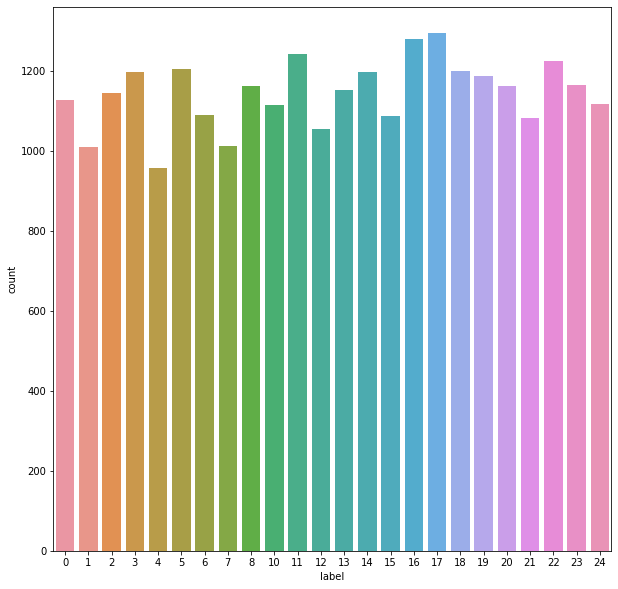

In [4]:
plt.figure(figsize=(10,10))
sns.countplot(train['label'])


In [5]:
y_train = train['label']
y_test  = test['label']
del train['label']
del test['label']

In [6]:
from sklearn.preprocessing import LabelBinarizer

In [7]:
lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
y_test  = lb.fit_transform(y_test)

In [8]:
X_train = train.values
X_test  = test.values

In [9]:
X_train

array([[107, 118, 127, ..., 204, 203, 202],
       [155, 157, 156, ..., 103, 135, 149],
       [187, 188, 188, ..., 195, 194, 195],
       ...,
       [174, 174, 174, ..., 202, 200, 200],
       [177, 181, 184, ...,  64,  87,  93],
       [179, 180, 180, ..., 205, 209, 215]], dtype=int64)

In [10]:
# Normalizing data
X_train = X_train / 255
X_test  = X_test  / 255

In [11]:
X_train = X_train.reshape(-1,28,28,1)
X_test  = X_test.reshape(-1, 28,28,1)

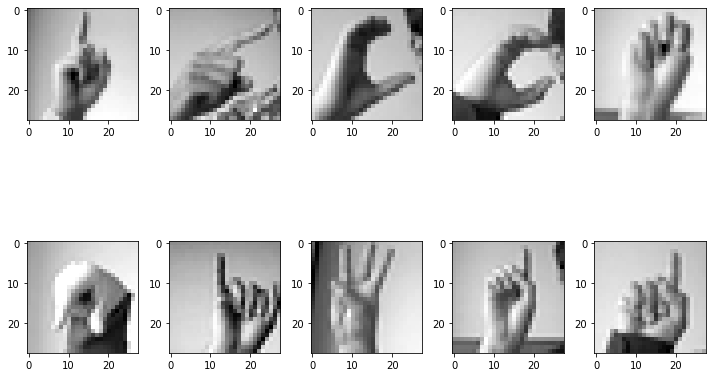

In [12]:
# Showing few images

f, ax = plt.subplots(2,5)
f.set_size_inches(10,10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_train[k].reshape(28,28), cmap='gray')
        k += 1
    plt.tight_layout()    
        
    

In [13]:
############# Data Augmentation ################
# with data augmentation we can save us from overfitting

dataGen = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
dataGen.fit(X_train)

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, 
                                            verbose=1,factor=0.5, min_lr=0.00001)

In [15]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 50)         

In [16]:
history = model.fit(dataGen.flow(X_train,y_train, batch_size = 128) ,epochs = 5 , 
                    validation_data = (X_test, y_test) , 
                    callbacks = [learning_rate_reduction])

Epoch 1/5
215/215 [==============================] - 268s 1s/step - loss: 1.0420 - accuracy: 0.6743 - val_loss: 3.2968 - val_accuracy: 0.1306
Epoch 2/5
215/215 [==============================] - 254s 1s/step - loss: 0.2108 - accuracy: 0.9316 - val_loss: 1.0162 - val_accuracy: 0.6636
Epoch 3/5
215/215 [==============================] - 237s 1s/step - loss: 0.0979 - accuracy: 0.9700 - val_loss: 0.1440 - val_accuracy: 0.9516
Epoch 4/5
215/215 [==============================] - 231s 1s/step - loss: 0.0634 - accuracy: 0.9801 - val_loss: 0.0814 - val_accuracy: 0.9750
Epoch 5/5
215/215 [==============================] - 231s 1s/step - loss: 0.0507 - accuracy: 0.9834 - val_loss: 0.1127 - val_accuracy: 0.9629


In [17]:
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

7172/7172 [==============================] - 19s 3ms/step
Accuracy of the model is -  96.2911307811737 %


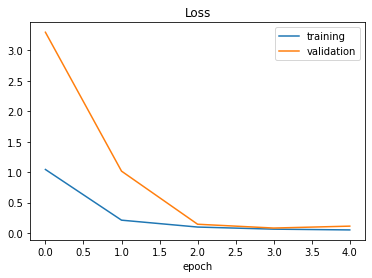

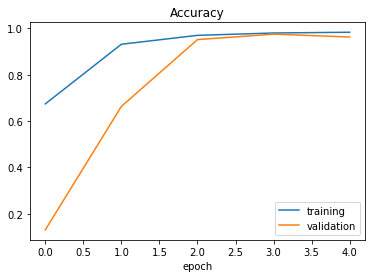

In [18]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [25]:
predictions = model.predict_classes(X_test)

In [26]:
model.save('sign.model')

In [27]:
className = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G',
             7:'H', 8:'I', 9:'K', 10:'L', 11:'M', 12:'N',
             13:'O', 14:'P', 15:'Q', 16:'R', 17:'S', 18:'T', 19:'U',
             20:'V', 21:'W', 22:'X', 23:'Y'}

In [28]:
print(np.argmax(y_test[2]))

9


In [29]:
y_test[:5]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])

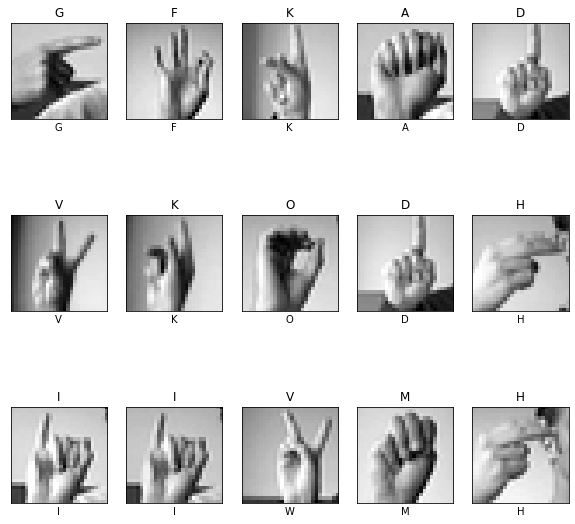

In [30]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i], cmap='gray')
    plt.title(className[np.argmax(y_test[i])])
    plt.xlabel(className[predictions[i]])
plt.show()